In [1]:
import os
import re
from collections import defaultdict

import torch
import numpy as np
import pandas as pd
from transformers import pipeline
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    cohen_kappa_score,
    classification_report,
    confusion_matrix,
)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, spearmanr

from models import Bleurt, Mpnet, ModernBERT, ModelInput

torch.set_float32_matmul_precision('high')
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [16]:
pipes = {
    "Mpnet_pipe":    Mpnet(),
    "Bleurt_pipe":   Bleurt(),
    "ModernBERT_pipe": ModernBERT()
}

Device set to use cuda
Device set to use cuda
Device set to use cuda


In [17]:
df = pd.read_csv("../../data/authentic_test_data.csv").rename(columns={
    "response": "candidate",
    "answer": "reference",
    "chunk_text": "text",
}).assign(
    label = lambda x: (x["human_score"] > 2).astype(int)
)
df.sample(5)

,candidate,ensemble_score,user_id,page_slug,chunk_slug,created_at,volume_slug,volume_title,page_title,chunk_header,text,question,reference,o3_mini_score,human_score,annotator,label
0,learning,0,clu91tykw0002l00fz3o1vfsh,emotional,01-Affect-Detection-from-Student-Activity-Data...,2024-04-15 19:57:38.656,cornell,Handbook of Learning Analytics,Emotional Learning Analytics,0.1 Affect Detection from Student Activity Data,Affective states cannot be directly measured b...,What approach was used to infer affect by anal...,"The interaction-based, log-file based, or sens...",1,1.0,langdon,0
1,answer,0,cluc0hclp0000ju0flnuywkrr,emotional,01-Affect-Detection-from-Student-Activity-Data...,2024-05-05 20:29:28.14,cornell,Handbook of Learning Analytics,Emotional Learning Analytics,0.1 Affect Detection from Student Activity Data,Affective states cannot be directly measured b...,What approach was used to infer affect by anal...,"The interaction-based, log-file based, or sens...",1,1.0,langdon,0
2,human observers made live annotations regardin...,0,clu7cooq9000kjt0fbxh29vfy,emotional,01-Affect-Detection-from-Student-Activity-Data...,2024-04-15 19:03:37.985,cornell,Handbook of Learning Analytics,Emotional Learning Analytics,0.1 Affect Detection from Student Activity Data,Affective states cannot be directly measured b...,What approach was used to infer affect by anal...,"The interaction-based, log-file based, or sens...",2,3.0,langdon,1
3,Recorded data from student while doing help ba...,0,clucz38h40005jv0fhc5vjpfp,emotional,01-Affect-Detection-from-Student-Activity-Data...,2024-03-30 01:56:12.488,cornell,Handbook of Learning Analytics,Emotional Learning Analytics,0.1 Affect Detection from Student Activity Data,Affective states cannot be directly measured b...,What approach was used to infer affect by anal...,"The interaction-based, log-file based, or sens...",2,3.0,langdon,1
4,analyzing context,0,clu8uwkw20000jz0f4yyg6c1d,emotional,01-Affect-Detection-from-Student-Activity-Data...,2024-05-03 20:56:52.298,cornell,Handbook of Learning Analytics,Emotional Learning Analytics,0.1 Affect Detection from Student Activity Data,Affective states cannot be directly measured b...,What approach was used to infer affect by anal...,"The interaction-based, log-file based, or sens...",2,2.0,langdon,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,trace refer to ambient data generated by learn...,2,clu7s2zh60005jt0gpk3z8at5,learning-analytics-for-self-regulated-learning,Data-For-Learning-Analytics-About-Learning-And...,2024-04-20 06:30:33.256,cornell,Handbook of Learning Analytics,Learning Analytics for Self-Regulated Learning,Data For Learning Analytics About Learning And...,"Traces\n\nAs learners work, they generate ambi...",What are traces and what do they reveal about ...,Traces are ambient data generated by learners ...,4,4.0,Tobasum,1
366,They are ambient data generated when learners ...,2,clu8s7sxo0005l50ft5mjtbjd,learning-analytics-for-self-regulated-learning,Data-For-Learning-Analytics-About-Learning-And...,2024-03-27 15:29:40.613,cornell,Handbook of Learning Analytics,Learning Analytics for Self-Regulated Learning,Data For Learning Analytics About Learning And...,"Traces\n\nAs learners work, they generate ambi...",What are traces and what do they reveal about ...,Traces are ambient data generated by learners ...,3,2.0,Tobasum,0
367,to make bindings in one module accessible in o...,1,fvbptwwe5elyvsqwx7cqgxs5fa,10-modules,ES-modules-845t,2024-09-11 16:04:14.815953+00,eloquent-javascript,Eloquent JavaScript,10. Modules,ES modules,The original JavaScript language did not have ...,What is the purpose of the export keyword in J...,The export keyword is used to indicate that a ...,3,3.0,Tobasum,1
368,"It is used to make function, class, object, or...",2,c35eotu6a3guavdkekjwe3346i,10-modules,ES-modules-845t,2024-09-10 19:11:56.866991+00,eloquent-javascript,Eloquent JavaScript,10. Modules,ES modules,The original JavaScript language did

In [29]:
def score(y_true, y_pred):  
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "precision_micro": precision_score(y_true, y_pred, average="micro", zero_division=0),
        "recall_micro": recall_score(y_true, y_pred, average="micro", zero_division=0),
        "f1_micro": f1_score(y_true, y_pred, average="micro", zero_division=0),
    }

def print_metrics(model_name, m: dict):
    print(f"{model_name}:")
    print(f"  Accuracy: {m['accuracy']:.4f}")
    print(f"  F1 (macro): {m['f1_macro']:.4f}")
    print(f"  F1 (micro): {m['f1_micro']:.4f}")
    print(f"  Precision (macro): {m['precision_macro']:.4f}")
    print(f"  Recall (macro): {m['recall_macro']:.4f}")
    print()

def evaluate_and_score(dataframe, pipes, label_key="labels"):
    all_preds = defaultdict(list)

    for name, pipe in pipes.items():
        for ex in df.to_dict('records'):
            model_input = ModelInput.from_dict(ex)
            pred = pipe(model_input)  
            all_preds[name].append(pred)

    score_gt_2 = [1 if score > 2 else 0 for score in dataframe["human_score"]]
    metrics = {
        name: score(score_gt_2, all_preds[name])
        for name in pipes
    }
    o3_mini_score_gt_2 = [1 if score > 2 else 0 for score in dataframe["o3_mini_score"]]
    metrics["o3_mini"] = score(score_gt_2, o3_mini_score_gt_2)
    return all_preds, metrics

all_preds, results = evaluate_and_score(df, pipes)

for model_name, m in results.items():
    print_metrics(model_name, m)

Mpnet_pipe:
  Accuracy: 0.7297
  F1 (macro): 0.7185
  F1 (micro): 0.7297
  Precision (macro): 0.7258
  Recall (macro): 0.7158

Bleurt_pipe:
  Accuracy: 0.7189
  F1 (macro): 0.7085
  F1 (micro): 0.7189
  Precision (macro): 0.7135
  Recall (macro): 0.7064

ModernBERT_pipe:
  Accuracy: 0.7270
  F1 (macro): 0.7031
  F1 (micro): 0.7270
  Precision (macro): 0.7387
  Recall (macro): 0.7005

o3_mini:
  Accuracy: 0.7054
  F1 (macro): 0.7033
  F1 (micro): 0.7054
  Precision (macro): 0.7532
  Recall (macro): 0.7333



In [28]:
result_df = pd.DataFrame.from_dict(results, orient='index')
result_df.round(4)

,accuracy,precision_macro,recall_macro,f1_macro,precision_micro,recall_micro,f1_micro
Mpnet_pipe,0.7297,0.7258,0.7158,0.7185,0.7297,0.7297,0.7297
Bleurt_pipe,0.7189,0.7135,0.7064,0.7085,0.7189,0.7189,0.7189
ModernBERT_pipe,0.7270,0.7387,0.7005,0.7031,0.7270,0.7270,0.7270
o3_mini,0.7054,0.7532,0.7333,0.7033,0.7054,0.7054,0.7054


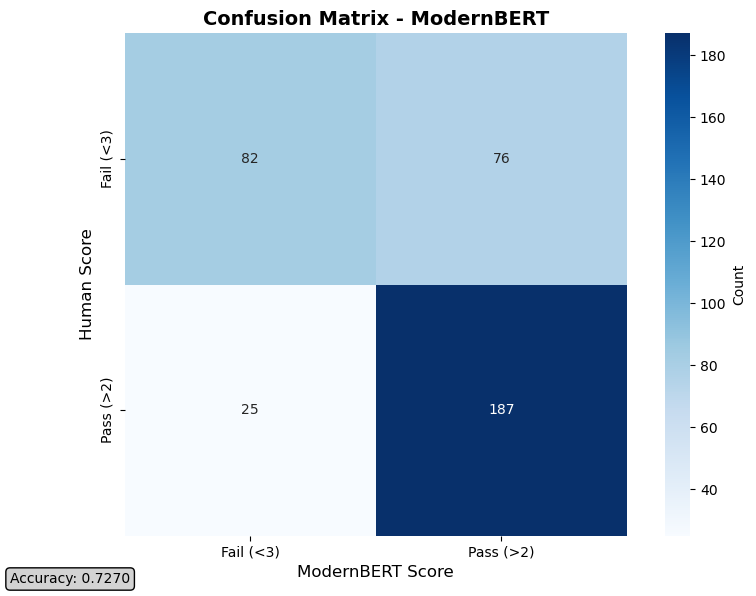

array([[ 82,  76],
       [ 25, 187]])

In [32]:
def plot_confusion_matrix_heatmap(y_true, y_pred, model_name="ModernBERT", figsize=(8, 6)):
    """
    Create a confusion matrix heatmap using seaborn.
    
    Parameters:
    y_true: True labels
    y_pred: Predicted labels  
    model_name: Name of the model for the title
    figsize: Figure size tuple
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Get unique labels for axis labels
    labels = sorted(list(set(y_true) | set(y_pred)))
    if len(labels) == 2:
        labels = ["Fail (<3)", "Pass (>2)"]
        
        
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Create heatmap
    sns.heatmap(cm, 
                annot=True,           # Show numbers in cells
                fmt='d',              # Format as integers
                cmap='Blues',         # Color scheme
                xticklabels=labels,   # X-axis labels
                yticklabels=labels,   # Y-axis labels
                cbar_kws={'label': 'Count'},
                square=True)          # Make cells square
    
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel(f'{model_name} Score', fontsize=12)
    plt.ylabel('Human Score', fontsize=12)
    plt.tight_layout()
    
    # Optional: Add accuracy to the plot
    accuracy = np.trace(cm) / np.sum(cm)
    plt.figtext(0.02, 0.02, f'Accuracy: {accuracy:.4f}', fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    
    plt.show()
    
    return cm

human_score_gt_2 = [1 if score > 2 else 0 for score in df["human_score"]]
plot_confusion_matrix_heatmap(human_score_gt_2, all_preds["ModernBERT_pipe"])

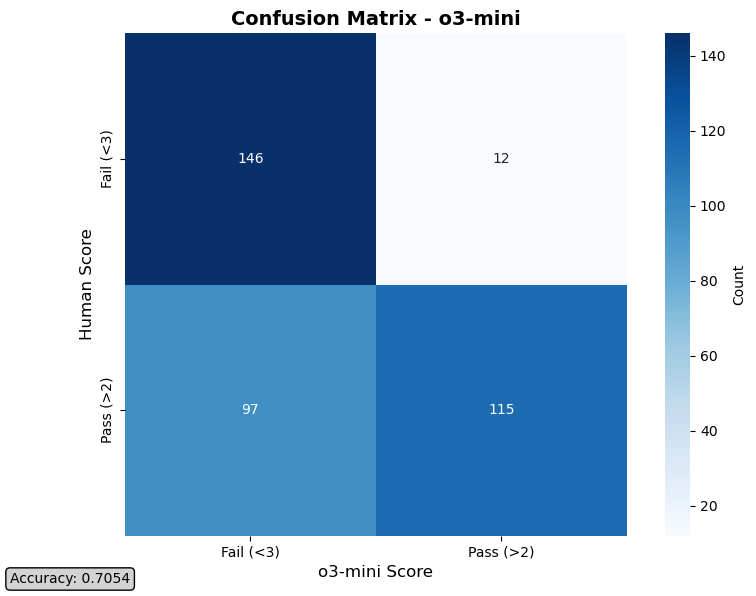

array([[146,  12],
       [ 97, 115]])

In [26]:
human_score_gt_2 = [1 if score > 2 else 0 for score in df["human_score"]]
o3_mini_score_gt_2 = [1 if score > 2 else 0 for score in df["o3_mini_score"]]
plot_confusion_matrix_heatmap(human_score_gt_2, o3_mini_score_gt_2, model_name="o3-mini")

o3 mini:
  Accuracy: 0.5162
  F1 (macro): 0.5266
  F1 (micro): 0.5162
  Precision (macro): 0.5569
  Recall (macro): 0.5488



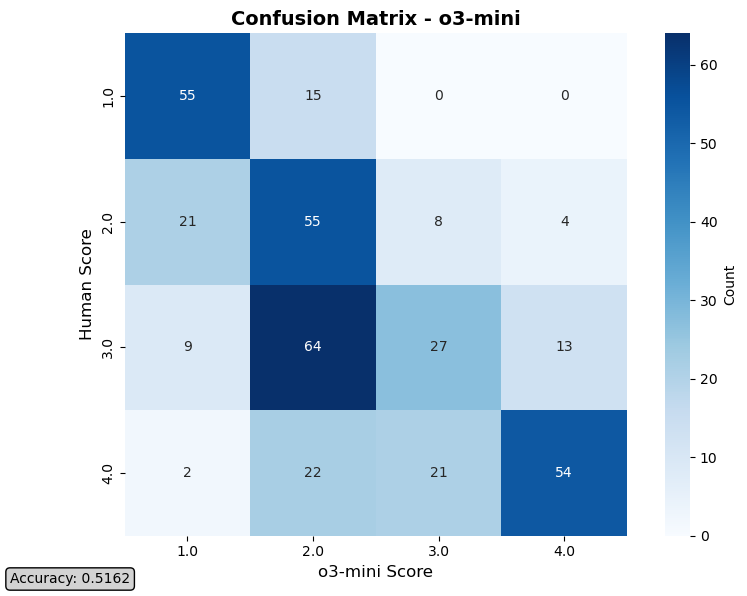

array([[55, 15,  0,  0],
       [21, 55,  8,  4],
       [ 9, 64, 27, 13],
       [ 2, 22, 21, 54]])

In [33]:
m = score(df["human_score"], df["o3_mini_score"])
print_metrics("o3 mini", m)
    
plot_confusion_matrix_heatmap(df["human_score"], df["o3_mini_score"], model_name="o3-mini")